##  multinomial logistic regression or the softmax classifier

In [52]:
import numpy as np
import random
SEED = 1234

In [53]:
np.random.seed(seed=SEED)
random.seed(SEED)

In [54]:
# load data 

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import json

In [56]:
# Read from CSV to Pandas DataFrame
url = "https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/tumors.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,leukocyte_count,blood_pressure,tumor_class
0,15.335860,14.637535,benign
1,9.857535,14.518942,malignant
2,17.632579,15.869585,benign
3,18.369174,14.774547,benign
4,14.509367,15.892224,malignant


In [57]:
# define label and input
X = df[['leukocyte_count', 'blood_pressure']].values
y = df['tumor_class'].values

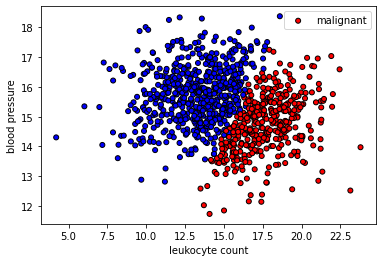

In [58]:
# Plot data
colors = {"benign": "red", "malignant": "blue"}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], s=25, edgecolors="k")
plt.xlabel("leukocyte count")
plt.ylabel("blood pressure")
plt.legend(["malignant", "benign"], loc="upper right")
plt.show()


In [59]:
# split data
import collections
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [60]:
def train_val_test_split(X, y, train_size):
    X_train, X_, y_train, y_ =  train_test_split(X, y, train_size=train_size, stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [61]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (700, 2), y_train: (700,)
X_val: (150, 2), y_val: (150,)
X_test: (150, 2), y_test: (150,)
Sample point: [14.95081332 14.86441305] → malignant


In [62]:
# overall class distribution
class_counts = dict(collections.Counter(y))
print(f"Classes: {class_counts}")
print(f"m:b = {class_counts['malignant']/class_counts['benign']:.2f}")

Classes: {'benign': 389, 'malignant': 611}
m:b = 1.57


In [63]:
# Per data split class distribution
train_class_counts = dict(collections.Counter(y_train))
val_class_counts = dict(collections.Counter(y_val))
test_class_counts = dict(collections.Counter(y_test))
print (f"train m:b = {train_class_counts['malignant']/train_class_counts['benign']:.2f}")
print (f"val m:b = {val_class_counts['malignant']/val_class_counts['benign']:.2f}")
print (f"test m:b = {test_class_counts['malignant']/test_class_counts['benign']:.2f}")


train m:b = 1.57
val m:b = 1.59
test m:b = 1.54


In [64]:
# Label encoding

import itertools

In [65]:
class LabelEncoder(object):
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [66]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
label_encoder.class_to_index

{'benign': 0, 'malignant': 1}

In [67]:
# Encoder
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
print (f"y_train[0]: {y_train[0]}")
print (f"decoded: {label_encoder.decode([y_train[0]])}")


y_train[0]: malignant
y_train[0]: 1
decoded: ['malignant']


In [68]:
# Class Weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print(f"counts: {counts}\nweights: {class_weights}")

counts: [272 428]
weights: {0: 0.003676470588235294, 1: 0.002336448598130841}


In [69]:
# standardize data
from sklearn.preprocessing import StandardScaler

In [70]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

In [71]:
# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)


In [72]:
# Check (means should be ~0 and std should be ~1)
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")


X_test[0]: mean: -0.1, std: 1.0
X_test[1]: mean: -0.2, std: 1.0


## NumPy

In [73]:
INPUT_DIM = X_train.shape[1]
NUM_CLASSES = len(label_encoder.classes)

In [74]:
# Initialize the weights
W = 0.01 * np.random.randn(INPUT_DIM, NUM_CLASSES)
b = np.zeros((1, NUM_CLASSES))
print (f"W: {W.shape}")
print (f"b: {b.shape}")

W: (2, 2)
b: (1, 2)


In [75]:
# Forward pass [NX2] · [2X2] + [1,2] = [NX2]
logits = np.dot(X_train, W) + b
print (f"logits: {logits.shape}")
print (f"sample: {logits[0]}")


logits: (700, 2)
sample: [-0.0069945   0.00647147]


In [76]:
# Normalization via softmax to obtain class probabilities
exp_logits = np.exp(logits)
y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
print (f"y_hat: {y_hat.shape}")
print (f"sample: {y_hat[0]}")


y_hat: (700, 2)
sample: [0.49663356 0.50336644]


In [77]:
# Loss
correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
loss = np.sum(correct_class_logprobs) / len(y_train)
print (f"loss: {loss:.2f}")


loss: 0.70


In [78]:
# Backpropagation
dscores = y_hat
dscores[range(len(y_hat)), y_train] -= 1
dscores /= len(y_train)
dW = np.dot(X_train.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)


In [79]:
# Update weights

LEARNING_RATE = 1e-1
W += -LEARNING_RATE * dW
b += -LEARNING_RATE * db


In [80]:
NUM_EPOCHS = 50


In [81]:
# Training loop
for epoch_num in range(NUM_EPOCHS):

    # Forward pass [NX2] · [2X2] = [NX2]
    logits = np.dot(X_train, W) + b

    # Normalization via softmax to obtain class probabilities
    exp_logits = np.exp(logits)
    y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Loss
    correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
    loss = np.sum(correct_class_logprobs) / len(y_train)

    # show progress
    if epoch_num%10 == 0:
        # Accuracy
        y_pred = np.argmax(logits, axis=1)
        accuracy =  np.mean(np.equal(y_train, y_pred))
        print (f"Epoch: {epoch_num}, loss: {loss:.3f}, accuracy: {accuracy:.3f}")

    # Backpropagation
    dscores = y_hat
    dscores[range(len(y_hat)), y_train] -= 1
    dscores /= len(y_train)
    dW = np.dot(X_train.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)

    # Update weights
    W += -LEARNING_RATE * dW
    b += -LEARNING_RATE * db


Epoch: 0, loss: 0.661, accuracy: 0.967
Epoch: 10, loss: 0.438, accuracy: 0.973
Epoch: 20, loss: 0.345, accuracy: 0.973
Epoch: 30, loss: 0.294, accuracy: 0.973
Epoch: 40, loss: 0.261, accuracy: 0.973


In [82]:
class LogisticRegressionFromScratch():
    def predict(self, x):
        logits = np.dot(x, W) + b
        exp_logits = np.exp(logits)
        y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return y_hat


In [83]:
# Evaluation
model = LogisticRegressionFromScratch()
logits_train = model.predict(X_train)
pred_train = np.argmax(logits_train, axis=1)
logits_test = model.predict(X_test)
pred_test = np.argmax(logits_test, axis=1)


In [84]:
# Training and test accuracy
train_acc =  np.mean(np.equal(y_train, pred_train))
test_acc = np.mean(np.equal(y_test, pred_test))
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")


train acc: 0.97, test acc: 0.00


In [85]:
def plot_multiclass_decision_boundary(model, X, y, savefig_fp=None):
    """Plot the multiclass decision boundary for a model that accepts 2D inputs.
    Credit: https://cs231n.github.io/neural-networks-case-study/

    Arguments:
        model {function} -- trained model with function model.predict(x_in).
        X {numpy.ndarray} -- 2D inputs with shape (N, 2).
        y {numpy.ndarray} -- 1D outputs with shape (N,).
    """
    # Axis boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Create predictions
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot
    if savefig_fp:
        plt.savefig(savefig_fp, format="png")


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['benign' 'malignant' 'malignant' 'malignant' 'malignant' 'malignant'
 'benign' 'malignant' 'malignant' 'benign' 'malignant' 'malignant'
 'benign' 'malignant' 'malignant' 'benign' 'benign' 'malignant' 'benign'
 'benign' 'malignant' 'malignant' 'malignant' 'malignant' 'malignant'
 'malignant' 'malignant' 'malignant' 'malignant' 'malignant' 'malignant'
 'benign' 'malignant' 'malignant' 'benign' 'malignant' 'malignant'
 'malignant' 'malignant' 'malignant' 'malignant' 'benign' 'malignant'
 'benign' 'malignant' 'malignant' 'benign' 'malignant' 'malignant'
 'benign' 'malignant' 'malignant' 'malignant' 'benign' 'benign' 'benign'
 'malignant' 'benign' 'malignant' 'malignant' 'malignant' 'benign'
 'malignant' 'malignant' 'malignant' 'malignant' 'benign' 'malignant'
 'benign' 'malignant' 'benign' 'malignant' 'malignant' 'benign' 'benign'
 'malignant' 'benign' 'malignant' 'benign' 'benign' 'malignant'
 'malignant' 'malignant' 'benign' 'benign' 'malignant' 'malignant'
 'benign' 'malignant' 'benign' 'malignant' 'malignant' 'benign'
 'malignant' 'malignant' 'malignant' 'benign' 'benign' 'malignant'
 'malignant' 'benign' 'benign' 'benign' 'malignant' 'malignant' 'benign'
 'malignant' 'benign' 'benign' 'malignant' 'benign' 'malignant' 'benign'
 'malignant' 'benign' 'malignant' 'benign' 'malignant' 'benign' 'benign'
 'benign' 'malignant' 'malignant' 'malignant' 'malignant' 'malignant'
 'malignant' 'malignant' 'benign' 'malignant' 'benign' 'benign' 'benign'
 'benign' 'benign' 'benign' 'malignant' 'benign' 'benign' 'malignant'
 'malignant' 'benign' 'malignant' 'benign' 'malignant' 'benign'
 'malignant' 'malignant' 'malignant' 'malignant']

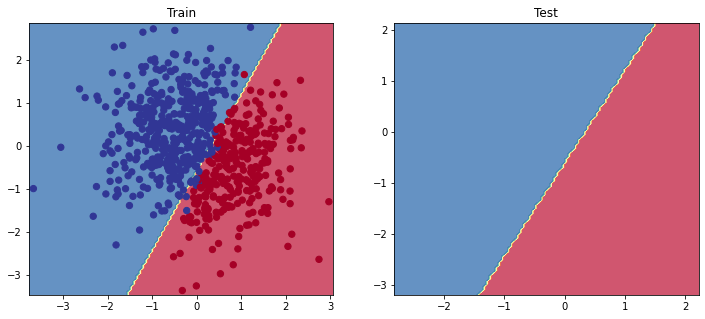

In [86]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()


## pyTorch

In [ ]:
import torch
torch.manual_seed(SEED)

In [ ]:
from torch import nn
import torch.nn.functional as F

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes)

    def forward(self, x_in):
        z = self.fc1(x_in)
        return z

In [ ]:
model = LogisticRegression(input_dim=INPUT_DIM, num_classes=NUM_CLASSES)
print(model.named_parameters)

<bound method Module.named_parameters of LogisticRegression(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
)>


In [ ]:
# loss
loss_function = nn.CrossEntropyLoss()
y_pred = torch.randn(3, NUM_CLASSES, requires_grad=False)
y_true = torch.empty(3, dtype=torch.long).random_(NUM_CLASSES)
print(y_true)
loss = loss_function(y_pred, y_true)
print(f"loss: {loss.numpy()}")

tensor([1, 0, 1])
loss: 0.2934693396091461


In [ ]:
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
def accuracy_function(y_pred, y_ture):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

In [ ]:
y_pred = torch.Tensor([0, 0, 1])
y_true = torch.Tensor([1, 1, 1])
print("Accuracy: {accuracy_fn(y_pred, y_true):.1f}")


Accuracy: {accuracy_fn(y_pred, y_true):.1f}


In [ ]:
from torch.optim import Adam
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)


In [ ]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [88]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%10==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")


TypeError: 'LogisticRegressionFromScratch' object is not callable